In [2]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np
from toolkit.dataset import load_spectral_data, dataset_dict_to_dense, normalize_spectra
import torch
def torchify(X, dtype=torch.float):
    return torch.from_numpy(X).type(dtype)

In [56]:
# Training data
dataset_dict = load_spectral_data([
    #"../raw_data/DataDavid/FTIR/*.asc",
    "../raw_data/DataDavid/FTIR/*.asc",
    "../raw_data/DataHenry23/FTIR/**/*.asc",
    "../raw_data/DataDavid/15_09_23/*.asc",
    #"../raw_data/DataHenry23/FTIR/**/*.asc",

], verbose=True)

#dataset_dict_v = load_spectral_data([
    #"../raw_data/DataHenry23/FTIR/**/*.asc",
#    "../raw_data/DataDavid/15_09_23/*.asc",
#], verbose=True)
X, Y = dataset_dict_to_dense(dataset_dict)
#mask_outliers = X.mean(axis=1) < 5
#X = X[mask_outliers, :]
#Y = Y[mask_outliers, :]
X = normalize_spectra(X, method="max")
npor = np.logical_or
mask_histo = npor(Y[:, 0]==6, npor(Y[:, 0]==9, npor(Y[:, 0]==4, npor(Y[:, 0]==11, Y[:, 0]==12))))
print(np.count_nonzero(mask_histo))
Xv = X[mask_histo]
Yv = Y[mask_histo]
X = X[~mask_histo]
Y = Y[~mask_histo]


#Xv, Yv = dataset_dict_to_dense(dataset_dict_v)
#Xv = normalize_spectra(Xv, method="max")

wavelength = np.flipud(np.linspace(450, 4000, 3551))
#wl_mask = wavelength <= 4000
#wavelength = wavelength[wl_mask]

X = X[:, :]
X = X[Y[:,5]< 10,:]
Y = Y[Y[:,5]< 10,:].astype(np.int32)

print(np.count_nonzero(Y[:, 1] == 0))
print(np.count_nonzero(Y[:, 1] == 1))
print(np.count_nonzero(Y[:, 1] == 2))

Xv = Xv[:, :]
Xv = Xv[Yv[:,5]< 10,:]
Yv = Yv[Yv[:,5]< 10,:].astype(np.int32)

labels = Y[:, 1]
labels_v = Yv[:, 1]



from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch

scaler = StandardScaler()
dsmean = X.mean(axis=0)
dsstd = X.std(axis=0) * 2
Xs = (X - dsmean) / dsstd
#Xs = scaler.fit_transform(X) / 5
#Xsv = scaler.transform(Xv) / 5
Xsv = (Xv-dsmean) / dsstd
loader = DataLoader(TensorDataset(torchify(Xs), torchify(labels, torch.long)), batch_size=8, shuffle=True)
loader_v = DataLoader(TensorDataset(torchify(Xsv), torchify(labels_v, torch.long)), batch_size=256, shuffle=False)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(200)
clf.fit(Xs, Y[:, 1])
print(np.count_nonzero(clf.predict(Xv) == Yv[:, 1]) / len(Yv[:, 1]))

Loading 80 files from ../raw_data/DataDavid/FTIR/*.asc
Loading 474 files from ../raw_data/DataHenry23/FTIR/**/*.asc
Loading 112 files from ../raw_data/DataDavid/15_09_23/*.asc
72
70
68
40
0.3888888888888889


In [38]:
from toolkit.networks import ConvolutionalAutoEncoder, count_parameters, AutoEncoder
import torch.nn as nn
import torch

class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, in_features, out_classes, complexity=2, latent_space=16, dropout=0.2):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.complexity = complexity
        self.in_features = in_features
        self.conv = nn.Sequential(
            nn.Linear(in_features, complexity),
            nn.Tanh(),
            nn.Linear(complexity, latent_space),
            nn.Tanh(),
        )
        
        self.deconv = nn.Sequential(
            nn.Linear(latent_space, complexity),
            nn.Tanh(),
            nn.Linear(complexity, in_features),
            nn.Tanh(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(latent_space, out_classes),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, X):
        code, classif = self.encode(X)
        return self.decode(code), classif
    def encode(self, X):
        X1 = self.conv(X)
        return X1, self.classifier(X1)
    def decode(self, X):
        return self.deconv(X)

ae = ConvolutionalAutoEncoder(len(wavelength), out_classes=3, complexity=32, latent_space=16, dropout=0.5)
print(count_parameters(ae))


231970


In [39]:
from torch.optim import Adam
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import trange
best_model = None
best_model_valid = 0.0
ae.train()
optim = Adam(ae.parameters(), lr=1e-5, weight_decay=1e-2)
#scheduler = StepLR(optim, step_size=10, gamma=0.95)
mse_loss = nn.MSELoss()
nll_loss = nn.NLLLoss()
progress = trange(200)
losses = list()
losses_t = list()
accs = list()
for e in progress:
    epoch_loss = 0.0
    ae.train()
    for x, y  in loader:
        bs = x.shape[0]
        ds = x.shape[1]
        #x = ((((x * dsstd) + dsmean) * (0.95 + 0.1 * torch.rand(bs, 1))) - dsmean) / dsstd
        #x = x.type(torch.float)
        #x = torch.from_numpy(scaler.inverse_transform(5*x) * (0.95 + 0.1 * np.random.rand(bs, 1)))
        #linear_deform = torch.randn(bs, 1) * (torch.from_numpy(wavelength)-(np.max(wavelength)-np.min(wavelength)/2)) * 1e-4
        
        #x += linear_deform
        #x = torch.from_numpy(1/5*scaler.transform(x)).type(torch.float)
        X_noisy = x + torch.randn(bs, ds) * 0.05
        X_noisy = X_noisy.reshape(bs, -1)
        x = x.reshape(bs, 1, -1)
        optim.zero_grad()
        xr, yp = ae(X_noisy)
        recons_loss = mse_loss(xr, x)
        classif_loss = nll_loss(yp, y)
        loss = 1 * classif_loss + recons_loss
        
        loss.backward()
        optim.step()
        epoch_loss += loss.cpu().item()

    with torch.no_grad():
        ae.eval()
        epoch_loss_t = 0.0
        mean_acc = 0.0
        num_samples = 0
        for x, y in loader_v:
            bs = x.shape[0]
            xp, yp = ae(x.reshape(bs, -1))
            loss = nll_loss(yp, y)
            epoch_loss_t += loss.item()
            mean_acc += np.count_nonzero(np.argmax(yp.detach().numpy(), 1) == y.detach().numpy())
            num_samples += len(y)
        epoch_loss_t /= len(loader_v)
        mean_acc /= num_samples
        losses_t.append(epoch_loss_t)
        accs.append(mean_acc)

    if mean_acc >= best_model_valid:
        best_model = ae.state_dict().copy()
        best_model_valid = mean_acc


    epoch_loss /= len(loader)
    progress.set_description(f"epoch {e} loss {round(epoch_loss, 4)} valid {round(epoch_loss_t, 5)}, acc {round(mean_acc, 3)} ")#lr {scheduler.get_last_lr()[0]:.1g}")
    losses.append(epoch_loss)
    #scheduler.step()

ae.load_state_dict(best_model)


  0%|          | 0/200 [00:00<?, ?it/s]/Users/kaeryv/prj/parchments2/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6, 1, 3551])) that is different to the input size (torch.Size([6, 3551])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch 199 loss 1.2177 valid 1.1847, acc 0.0 : 100%|██████████| 200/200 [00:17<00:00, 11.66it/s] 


<All keys matched successfully>

1.2671053409576416


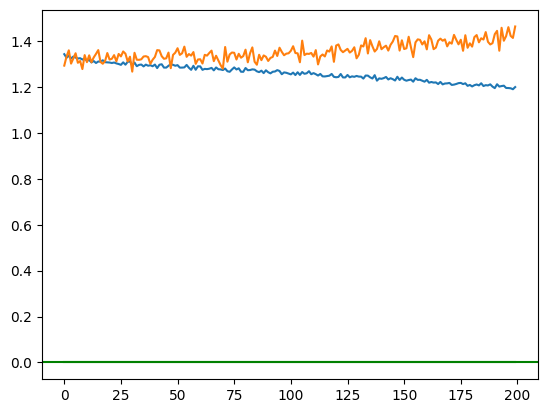

In [36]:
plt.plot(losses)
plt.plot(losses_t)
plt.plot(accs)
plt.axhline(best_model_valid, color="green")
print(np.min(losses_t))
torch.save({"model": ae.state_dict(), "optim": optim }, "model_001.pkl")

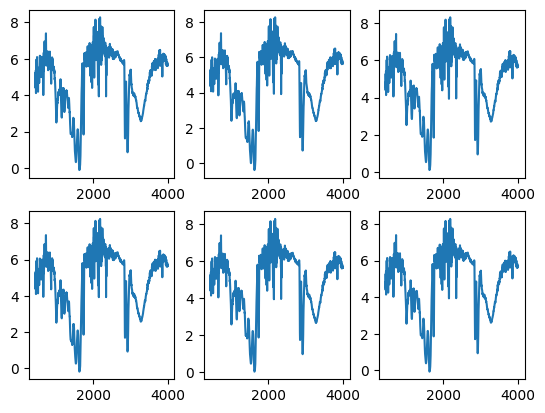

In [165]:
fig, axs = plt.subplots(2,3)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(wavelength, x[i])
    #ax.plot(scaler.inverse_transform(xp[i].detach().numpy())[0])

In [ ]:
import os
from glob import glob
files = glob("../raw_data/DataHenry23/FTIR/**/*.asc", recursive=True)
for file in files:
    #os.rename(file, file.replace("/3G", "/003-3G"))
    print(file)

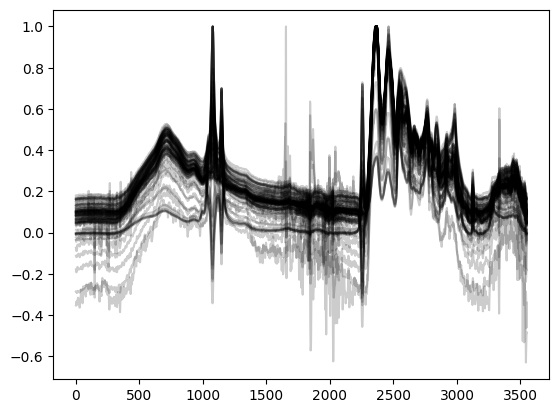

In [12]:
_ = plt.plot(X.T, color="k", alpha=0.2)
#outliers = np.flipud(np.argsort(np.sum(np.abs(X), axis=-1)))[0:4]
#for o in outliers:
#    plt.plot(X[o], color="r", alpha=0.3)
#    print(list(dataset_dict.keys())[o])


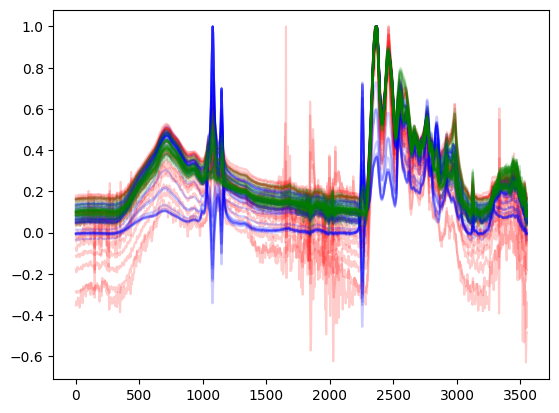

In [17]:
_ = plt.plot(X[Y[:,1]==0].T, color="r", alpha=0.2)
_ = plt.plot(X[Y[:,1]==1].T, color="b", alpha=0.2)
_ = plt.plot(X[Y[:,1]==2].T, color="g", alpha=0.2)

In [89]:
dataset_dict = load_spectral_data([
    "../raw_data/DataDavid/FTIR/*.asc",
    "../raw_data/DataHenry23/FTIR/**/*.asc",
    "../raw_data/DataDavid/15_09_23/*.asc",
], verbose=True)

X, Y = dataset_dict_to_dense(dataset_dict)
mask_outliers = X.mean(axis=1) < 5
X = X[mask_outliers, :]
Y = Y[mask_outliers, :]
X = normalize_spectra(X, method="sum")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)
Xsv = scaler.transform(Xs)
#model = PCA(3, whiten=True)
model2 = TSNE(2, perplexity=20)
#l = model.fit_transform(Xs)
lv = model2.fit_transform(Xs)

Loading 80 files from ../raw_data/DataDavid/FTIR/*.asc
Loading 474 files from ../raw_data/DataHenry23/FTIR/**/*.asc
Loading 112 files from ../raw_data/DataDavid/15_09_23/*.asc


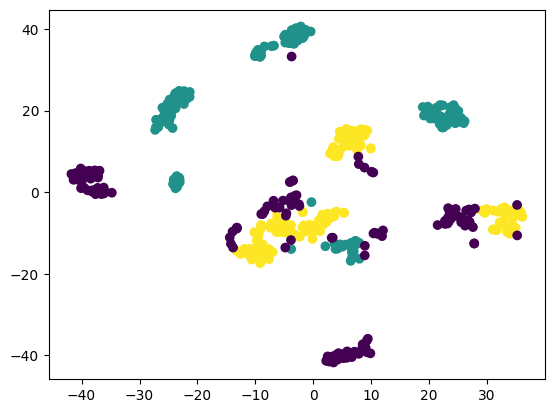

In [90]:
plt.scatter(*lv.T, c=Y[:, 1])


1.0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])